In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import vlc
from tqdm import tqdm

In [2]:
train = pd.read_csv('data/en/train.tsv', sep='\t')
train = train[['client_id', 'path', 'age', 'gender', 'sentence']].dropna()
train = train[train['gender'] != 'other']

In [3]:
train.shape

(322504, 5)

In [4]:
print(train.shape[0]/train['client_id'].nunique())
print()

46.87558139534884



In [5]:
train.columns

Index(['client_id', 'path', 'age', 'gender', 'sentence'], dtype='object')

In [30]:
from modules.DataPreprocessor import DataLoader
dl = DataLoader()
audio = np.array(dl.load_audio_binary(500))
spec = dl.make_spectrogram(500)

array([[-53.54582, -53.54582, -53.54582, ..., -53.54582, -53.54582,
        -53.54582],
       [-53.54582, -53.54582, -53.54582, ..., -53.54582, -53.54582,
        -53.54582],
       [-53.54582, -53.54582, -53.54582, ..., -53.54582, -53.54582,
        -53.54582],
       ...,
       [-53.54582, -53.54582, -53.54582, ..., -53.54582, -53.54582,
        -53.54582],
       [-53.54582, -53.54582, -53.54582, ..., -53.54582, -53.54582,
        -53.54582],
       [-53.54582, -53.54582, -53.54582, ..., -53.54582, -53.54582,
        -53.54582]], dtype=float32)

In [35]:
def show_and_play(case_num, train=train):
    from modules.DataPreprocessor import DataLoader
    dl = DataLoader()
    audio = np.array(dl.load_audio_binary(case_num))
    spec = dl.make_spectrogram(case_num)
    path = dl.get_path(case_num)
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.imshow(spec[~np.all(spec==np.min(spec), axis=1)]
        , cmap='plasma', interpolation='nearest', aspect='auto')
    print('Recording:\t', case_num, '/', train.shape[0]-1)
    print('Client ID:\t', train['client_id'].iloc[case_num])
    print('Sentence:\t', train['sentence'].iloc[case_num])
    print('Age:\t\t', train['age'].iloc[case_num])
    print('Gender:\t\t', train['gender'].iloc[case_num])

    p = vlc.MediaPlayer(path)
    p.play()

Recording:	 501 / 322503
Client ID:	 0e822d3961dc2cfaf0a57414b90df5950a5ddfc6d5790839c142decc25fde033546c122852e77ea470ba52ecb307de40154fcec4d1f3db42aa3d4a1099a6de35
Sentence:	 The move resulted in the discovery of oil near Big Valley.
Age:		 twenties
Gender:		 male


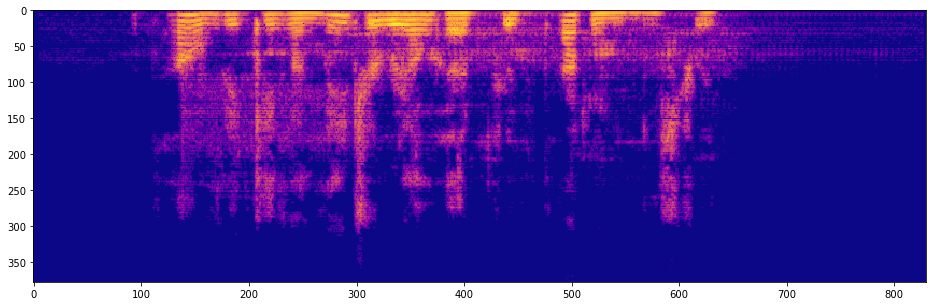

In [38]:
show_and_play(50, train)

In [82]:
(train['age'].value_counts()/(train['age'].shape[0]+1))*100

twenties     37.374304
thirties     19.623882
fourties     16.929040
sixties      10.913939
fifties       7.173222
teens         6.681757
seventies     1.152540
eighties      0.134572
nineties      0.016434
Name: age, dtype: float64

In [83]:
train['age'].map({'teens':0, 'twenties':1, 'seventies':2, 'fifties':3, 'fourties':4,
       'thirties':5, 'sixties':6, 'eighties':7, 'nineties':8}).unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [84]:
train['gender'].map({'male':0, 'female':1}).unique()

array([0, 1])

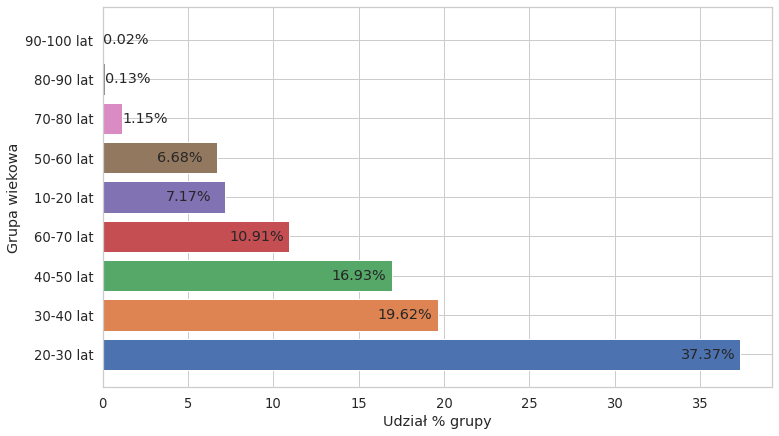

In [39]:
import seaborn as sns
sns.set(font_scale=1.2, style='whitegrid')
colors = sns.color_palette()

labels = ['20-30 lat', '30-40 lat', '40-50 lat', '60-70 lat', '10-20 lat', '50-60 lat', '70-80 lat', '80-90 lat', '90-100 lat']
values = (train['age'].value_counts()/(train['age'].shape[0]+1))*100

fig, ax = plt.subplots(figsize=(12, 7))
ax.barh(
    labels,
    values,
    color=(colors[0], colors[1], colors[2], colors[3], colors[4], colors[5], colors[6], colors[7], colors[8])
    )
ax.set(xlabel='Udział % grupy', ylabel='Grupa wiekowa')
# ax.set(title='Dystrybucja wieku w zbiorze treningowym')
for index, value in enumerate(values):
    if value>5:
        ax.text(value-3.5, index-0.1, str(np.round(value, 2))+'%')
    else:
        ax.text(value, index-0.1, str(np.round(value, 2))+'%')
fig.savefig(os.path.join('figures', 'distribution_age_before.pdf'), bbox_inches='tight')

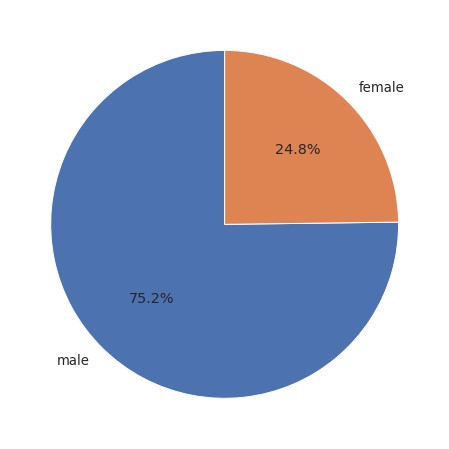

In [86]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.pie(train['gender'].value_counts(), labels=train['gender'].value_counts().index, autopct='%1.1f%%',
        shadow=False, startangle=90)
plt.show()
fig.savefig(os.path.join('figures', 'distribution_gender_before.pdf'), bbox_inches='tight')

## MAKING DATA SMALLER 

In [87]:
ages_counts = train['age'].value_counts()
ages_counts

twenties     120534
thirties      63288
fourties      54597
sixties       35198
fifties       23134
teens         21549
seventies      3717
eighties        434
nineties         53
Name: age, dtype: int64

In [88]:
gender_counts = train['gender'].value_counts()
gender_counts

male      242541
female     79963
Name: gender, dtype: int64

### Make distribution between teens and seventies even for both men and women

In [89]:
data_cut_1 = pd.read_csv('data_info.csv')

In [90]:
# data_cut_1 = pd.concat(
#     (train[(train['gender']=='male') & (~train['age'].isin(['eighties', 'nineties']))].sample(gender_counts['female']),
#      train[(train['gender']=='female') & (~train['age'].isin(['eighties', 'nineties']))],
#      train[(train['age'].isin(['eighties', 'nineties']))])                     )

In [91]:
ages_counts = data_cut_1['age'].value_counts()
ages_counts

teens        5998
thirties     5997
twenties     5997
fifties      5993
sixties      5989
fourties     5979
seventies    2344
eighties      433
nineties       52
Name: age, dtype: int64

In [92]:
# data_cut_2 = pd.DataFrame()
# sample_size = 6000
# for age in data_cut_1['age'].unique():
#     try:
#         data_cut_2 = pd.concat(
#         (data_cut_2, data_cut_1[data_cut_1['age']==age].sample(sample_size))
#         )
#     except:
#         print('sample size', sample_size, 'bigger than population for age:', age, '[Using all data]')
#         data_cut_2 = pd.concat(
#         (data_cut_2, data_cut_1[data_cut_1['age']==age].sample(ages_counts[age]))
#         )

In [93]:
train = pd.read_csv('data_info.csv')

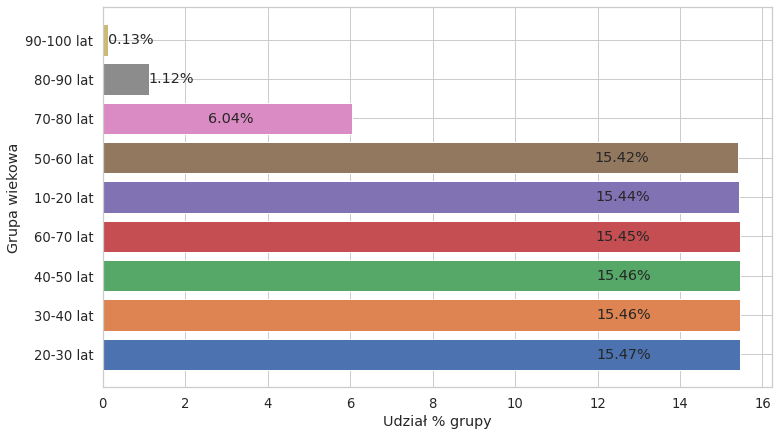

In [94]:
import seaborn as sns
sns.set(font_scale=1.2, style='whitegrid')
colors = sns.color_palette()

labels = ['20-30 lat', '30-40 lat', '40-50 lat', '60-70 lat', '10-20 lat', '50-60 lat', '70-80 lat', '80-90 lat', '90-100 lat']
values = (train['age'].value_counts()/(train['age'].shape[0]+1))*100

fig, ax = plt.subplots(figsize=(12, 7))
ax.barh(
    labels,
    values,
    color=(colors[0], colors[1], colors[2], colors[3], colors[4], colors[5], colors[6], colors[7], colors[8])
    )
ax.set(xlabel='Udział % grupy', ylabel='Grupa wiekowa')
# ax.set(title='Dystrybucja wieku w zbiorze treningowym')
for index, value in enumerate(values):
    if value>5:
        ax.text(value-3.5, index-0.1, str(np.round(value, 2))+'%')
    else:
        ax.text(value, index-0.1, str(np.round(value, 2))+'%')
fig.savefig(os.path.join('figures', 'distribution_age.pdf'), bbox_inches='tight')

In [40]:
pd.read_csv('data_info.csv')

,Unnamed: 0,client_id,path,age,gender,sentence,length
0,0,7eff9a54bdb0619deffda7609d5b8565278e3328de99e6...,common_voice_en_19956141.mp3,sixties,female,He had success right off the bat with Do You B...,266112
1,1,3dbc57adea9742c6782b7c88b7ac313e4bb7e26374db2e...,common_voice_en_20012566.mp3,fourties,female,"While the Doctor aids Clent, Penley leaves the...",252288
2,2,5b1dd93d15c860f4d94c18ca33bb896b1b4a4f2f95f253...,common_voice_en_18343993.mp3,teens,male,The hyena proceeded to dine.,161280
3,3,70c21ca1cc3de05f3c23b11615cd7d5dd078e03cda0cd4...,common_voice_en_20791392.mp3,fifties,female,"In Manchuria and Siberia, they mate during Jan...",271872
4,4,db94fba2e15010f1a4aa114d910ac1e1a320c5dbd692a3...,common_voice_en_20005534.mp3,fourties,male,The reconfigured centre would have been brande...,205056
...,...,...,...,...,...,...,...
38777,38831,4ba8b91d601ee7f27be3011552ea94c8d076d9816d4a77...,common_voice_en_19769331.mp3,seventies,female,The first volume was written during Ovid's jou...,288000
38778,38832,afcc38200b25a04019f5e3125535f1d93674ad6f0be9ac...,common_voice_en_193416.mp3,sixties,female,Play Lil Hardin Armstrong from Itunes.,253440
38779,38833,e140a69135f35bc81e98140a267e18a382807d684099be...,common_voice_en_21169446.mp3,twenties,male,It is primarily a farming community.,196992
38780,38834,64bb74229c8a05aeeebe8aeb498d5a0389479625a0085d...,common_voice_en_19761030.mp3,twenties,male,The Ewings had thirteen children.,171648


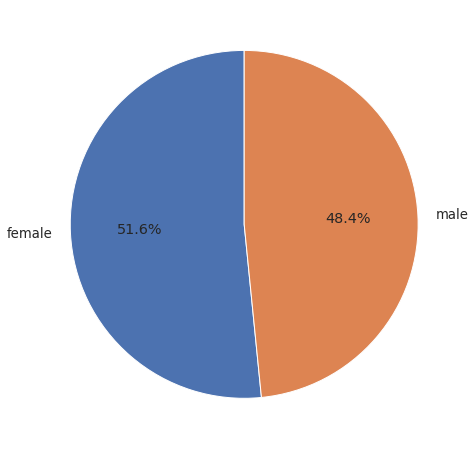

In [95]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.pie(train['gender'].value_counts(), labels=train['gender'].value_counts().index, autopct='%1.1f%%',
        shadow=False, startangle=90)
plt.show()
fig.savefig(os.path.join('figures', 'distribution_gender.pdf'), bbox_inches='tight')

In [96]:
# train_og = pd.read_csv('data/en/train.tsv', sep='\t')
# train_og = train_og[['client_id', 'path', 'age', 'gender', 'sentence']].dropna()
# train_og = train_og[train_og['gender'] != 'other']


# lengths = []
# for case_num in tqdm(train.index.values):
#     path = str('data/en/clips/' + train_og['path'].loc[case_num])
#     audio_binary = tf.io.read_file(path)
#     audio = tfio.audio.decode_mp3(audio_binary)
#     lengths.append(len(audio))
# train['length'] = lengths
# train = train.sample(frac=1).reset_index(drop=True)
# train = train[train['length']<500000]
# train.to_csv('data_info.csv')

In [97]:
train

,Unnamed: 0,client_id,path,age,gender,sentence,length
0,0,7eff9a54bdb0619deffda7609d5b8565278e3328de99e6...,common_voice_en_19956141.mp3,sixties,female,He had success right off the bat with Do You B...,266112
1,1,3dbc57adea9742c6782b7c88b7ac313e4bb7e26374db2e...,common_voice_en_20012566.mp3,fourties,female,"While the Doctor aids Clent, Penley leaves the...",252288
2,2,5b1dd93d15c860f4d94c18ca33bb896b1b4a4f2f95f253...,common_voice_en_18343993.mp3,teens,male,The hyena proceeded to dine.,161280
3,3,70c21ca1cc3de05f3c23b11615cd7d5dd078e03cda0cd4...,common_voice_en_20791392.mp3,fifties,female,"In Manchuria and Siberia, they mate during Jan...",271872
4,4,db94fba2e15010f1a4aa114d910ac1e1a320c5dbd692a3...,common_voice_en_20005534.mp3,fourties,male,The reconfigured centre would have been brande...,205056
...,...,...,...,...,...,...,...
38777,38831,4ba8b91d601ee7f27be3011552ea94c8d076d9816d4a77...,common_voice_en_19769331.mp3,seventies,female,The first volume was written during Ovid's jou...,288000
38778,38832,afcc38200b25a04019f5e3125535f1d93674ad6f0be9ac...,common_voice_en_193416.mp3,sixties,female,Play Lil Hardin Armstrong from Itunes.,253440
38779,38833,e140a69135f35bc81e98140a267e18a382807d684099be...,common_voice_en_21169446.mp3,twenties,male,It is primarily a farming community.,196992
38780,38834,64bb74229c8a05aeeebe8aeb498d5a0389479625a0085d...,common_voice_en_19761030.mp3,twenties,male,The Ewings had thirteen children.,171648


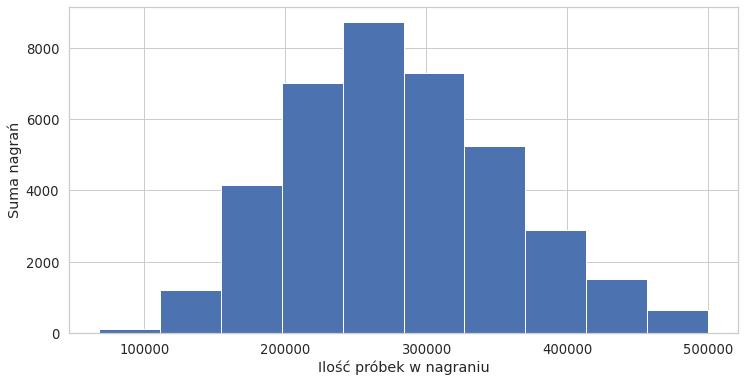

In [98]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(train['length']);
ax.set(xlabel='Ilość próbek w nagraniu', ylabel='Suma nagrań')
fig.savefig(os.path.join('figures', 'histogram.pdf'))

In [99]:
train.

SyntaxError: invalid syntax (<ipython-input-99-4ad677fcc250>, line 1)